# 01 - Qiskit Quickstart: Classification with Sampler and NoiseProfile

This notebook shows how to:

- Build a small parameterized Qiskit circuit.
- Wrap a `Sampler` with `wrap_qiskit_sampler`.
- Use `ShotBootstrap` for predictive distributions.
- Run `NoiseProfile` to study stability vs. shots.

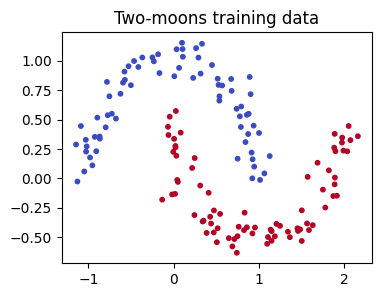

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler

from quantumuq import ShotBootstrap, NoiseProfile, wrap_qiskit_sampler, ece, nll
from quantumuq.datasets.toy import make_moons

rng = np.random.default_rng(0)
dataset = make_moons(n_samples=200, noise=0.1, random_state=0)
X, y = dataset.X, dataset.y

perm = rng.permutation(len(X))
train_idx, test_idx = perm[:150], perm[150:]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

plt.figure(figsize=(4, 3))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", s=10)
plt.title("Two-moons training data")
plt.show()

In [2]:
# Build a simple 1-qubit circuit with a single parameter.
theta = Parameter("theta")
qc = QuantumCircuit(1)
qc.ry(theta, 0)
qc.measure_all()

def feature_map(X: np.ndarray):
    X_arr = np.asarray(X)
    if X_arr.ndim == 1:
        X_arr = X_arr[0:1]
    # Map first feature to rotation.
    return [[float(x[0])] for x in X_arr]

sampler = Sampler()

predictor = wrap_qiskit_sampler(
    sampler=sampler,
    circuit=qc,
    task="classification",
    n_classes=2,
    feature_map=feature_map,
)

uq = ShotBootstrap(n_samples=8, shots=1000, seed=0)
uq_model = predictor.with_uq(uq)

dist = uq_model.predict_dist(X_test)
probs = dist.mean
y_pred = probs.argmax(axis=1)

test_nll = nll(y_test, probs)
test_ece = ece(y_test, probs, n_bins=10)
print(f"Test NLL: {test_nll:.3f}, ECE: {test_ece:.3f}")

Test NLL: 1.084, ECE: 0.271


/var/folders/rh/1c0lrj_x0x956417g86lc4ph0000gn/T/ipykernel_16656/2109316916.py:14: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


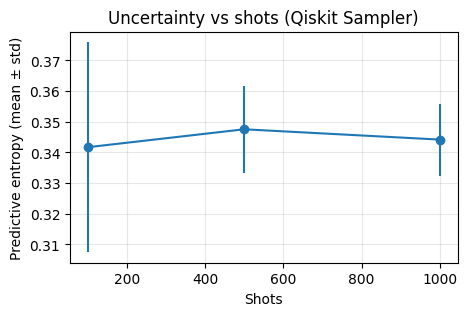

In [3]:
# NoiseProfile: shot sweep
profile = NoiseProfile(sweep_shots=[100, 500, 1000], n_repeats=4)
results = profile(predictor, X_test[:40])

shots_list = sorted(results.keys())
mean_entropies = [results[s]["mean_entropy"].mean() for s in shots_list]
std_entropies = [results[s]["std_entropy"].mean() for s in shots_list]

plt.figure(figsize=(5, 3))
plt.errorbar(shots_list, mean_entropies, yerr=std_entropies, fmt="o-")
plt.xlabel("Shots")
plt.ylabel("Predictive entropy (mean ± std)")
plt.title("Uncertainty vs shots (Qiskit Sampler)")
plt.grid(True, alpha=0.3)
plt.show()

## Interpreting the Qiskit quickstart

- The `Sampler` primitive returns **quasi-distributions** over bitstrings.
- `wrap_qiskit_sampler` converts these to class probabilities with a default
  bitstring-to-class mapping (integer value modulo `n_classes`).
- `ShotBootstrap` resamples the circuit multiple times to approximate the
  **predictive distribution** over outputs.
- `NoiseProfile` sweeps over different shot counts and summarizes how
  probabilities and entropies vary with measurement statistics.